In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/passengers-eu/Processed_Passengers.xlsx
/kaggle/input/tourism-2022-09/tour_occ_nim__custom_3714702_linear.csv
/kaggle/input/tourism-2022-09/tour_occ_nim__custom_3437776_linear.csv


# 1. Backgroud

It is a notebook for the Statistics-awards in EU. More information is available at
https://statistics-awards.eu/. Most of the data are available from Eurostat: 
https://ec.europa.eu/eurostat/databrowser/view/tour_occ_nim/default/table?lang=en.

This notebook is for the forecasting of Tourism, one of the three competitions. The data are for Number of nights spent at tourist accommodation establishments (Eurobase code: TOUR_OCC_NIM, UNIT:NR, NACE R2: I551-I553, INDIC TO: B006).


# 2. EDA

Data have been downloaded from Eurostat and uploaded to Kaggle. Some of the time series will be showen.

In [120]:
## Load data
filepath = "/kaggle/input/tourism-2022-09/tour_occ_nim__custom_3714702_linear.csv"
tour = pd.read_csv(filepath, 
                   usecols = ['c_resid','nace_r2','geo','TIME_PERIOD','OBS_VALUE'],
                   parse_dates = ['TIME_PERIOD'],
                   infer_datetime_format = True,
                  )
tour.tail()

,c_resid,nace_r2,geo,TIME_PERIOD,OBS_VALUE
48259,TOTAL,I552_I553,XK,2022-04-01,2484.0
48260,TOTAL,I552_I553,XK,2022-05-01,2293.0
48261,TOTAL,I552_I553,XK,2022-06-01,4579.0
48262,TOTAL,I552_I553,XK,2022-07-01,24164.0
48263,TOTAL,I552_I553,XK,2022-08-01,10697.0


In [121]:
# The table of number of passengers 

filePass = "../input/passengers-eu/Processed_Passengers.xlsx"
passenger = pd.read_excel(filePass)
passenger.tail()

,geo,TIME_PERIOD,pas
3715,SK,2022-07-01,116456
3716,SK,2022-08-01,115697
3717,SK,2022-09-01,86377
3718,SK,2022-10-01,56476
3719,SK,2022-11-01,41908


In [122]:
# select only necessary countries
TourLand = ["AT", "BE", "CY", "CZ", "DE", "DK", "EL", "ES", "FI", "FR", "HR", "HU", "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]

tour2 = tour.loc[(tour['geo'].isin(TourLand))&(tour['c_resid']=="TOTAL")]
tour3 = tour2.drop('c_resid',axis=1)
tour3.sort_values(by=['nace_r2','geo','TIME_PERIOD'],inplace=True)
tour3.tail()

,nace_r2,geo,TIME_PERIOD,OBS_VALUE
48032,I552_I553,SK,2022-05-01,231712.0
48033,I552_I553,SK,2022-06-01,311655.0
48034,I552_I553,SK,2022-07-01,596593.0
48035,I552_I553,SK,2022-08-01,581090.0
48036,I552_I553,SK,2022-09-01,289204.0


In [123]:
# import other packages and set up figures
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.deterministic import DeterministicTerm, Seasonality, TimeTrend
from xgboost import XGBRegressor

from warnings import simplefilter
# Ignore warnings
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

print("setup complete.")

setup complete.


It is difficult to show figures for all countries. We take two examples (Germany and Spain).

In [124]:
_data = tour3.loc[(tour3['geo'].isin(["DE","ES"])) & (tour3['nace_r2']=='I551-I553')]
_data.head()

,nace_r2,geo,TIME_PERIOD,OBS_VALUE
38546,I551-I553,DE,2010-01-01,15187910.0
38547,I551-I553,DE,2010-02-01,16926508.0
38548,I551-I553,DE,2010-03-01,19727756.0
38549,I551-I553,DE,2010-04-01,23879801.0
38550,I551-I553,DE,2010-05-01,31471747.0


In [125]:
#data for number of passengers

_passenger = passenger.loc[passenger['geo'].isin(["DE","ES"])]

In [126]:
#help(sns.lineplot)

<AxesSubplot:xlabel='TIME_PERIOD', ylabel='OBS_VALUE'>

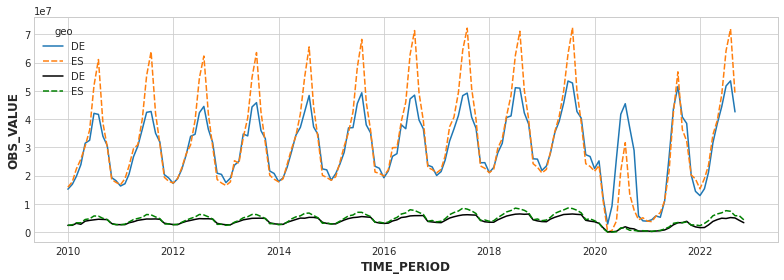

In [127]:
ax1 = sns.lineplot(data=_data,x="TIME_PERIOD",hue="geo",style="geo", y="OBS_VALUE")
sns.lineplot(data=_passenger,x="TIME_PERIOD",hue="geo",y="pas",style="geo", palette=["black","green"], ax=ax1)

As the figure shows, it is apparent that there are trend and seasonality in those series.

# 3. Boosted Hybrid

**Idea: to use deterministic trend and seasonal component (calendar fourier) for linreg in model 1
and XGBOOST in model 2.**

Some classes from Kaggle and Statmodels are utilized.

In [128]:
'''
## Define a class for Hybrid Boost method for forecasting of TS

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

def fit(self, X_1, X_2, y):
    # YOUR CODE HERE: fit self.model_1
    self.model_1.fit(X_1,y)

    y_fit = pd.DataFrame(
        # YOUR CODE HERE: make predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # YOUR CODE HERE: compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # YOUR CODE HERE: fit self.model_2 on residuals
    self.model_2.fit(X_2,y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # YOUR CODE HERE: predict with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # YOUR CODE HERE: add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add method to class
BoostedHybrid.predict = predict
'''

'\n## Define a class for Hybrid Boost method for forecasting of TS\n\nclass BoostedHybrid:\n    def __init__(self, model_1, model_2):\n        self.model_1 = model_1\n        self.model_2 = model_2\n        self.y_columns = None  # store column names from fit method\n\ndef fit(self, X_1, X_2, y):\n    # YOUR CODE HERE: fit self.model_1\n    self.model_1.fit(X_1,y)\n\n    y_fit = pd.DataFrame(\n        # YOUR CODE HERE: make predictions with self.model_1\n        self.model_1.predict(X_1),\n        index=X_1.index, columns=y.columns,\n    )\n\n    # YOUR CODE HERE: compute residuals\n    y_resid = y - y_fit\n    y_resid = y_resid.stack().squeeze() # wide to long\n\n    # YOUR CODE HERE: fit self.model_2 on residuals\n    self.model_2.fit(X_2,y_resid)\n\n    # Save column names for predict method\n    self.y_columns = y.columns\n    # Save data for question checking\n    self.y_fit = y_fit\n    self.y_resid = y_resid\n\n\n# Add method to class\nBoostedHybrid.fit = fit\n\ndef predict(self

In [129]:
starttime= datetime.now()

In [2]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid
'''
# Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=ElasticNet(),
    model_2=MLPRegressor(),
)
'''


'\n# Try different combinations of the algorithms above\nmodel = BoostedHybrid(\n    model_1=ElasticNet(),\n    model_2=MLPRegressor(),\n)\n'

In [131]:
class BrokenTimeTrend(DeterministicTerm):
    def __init__(self, break_period: int):
        self._break_period = break_period

    def __str__(self):
        return "Broken Time Trend"

    def _eq_attr(self):
        return (self._break_period,)

    def in_sample(self, index: pd.Index):
        nobs = index.shape[0]
        terms = np.zeros((nobs, 2))
        terms[self._break_period :, 0] = 1
        terms[self._break_period :, 1] = np.arange(self._break_period + 1, nobs + 1)
        return pd.DataFrame(terms, columns=["const_break", "trend_break"], index=index)

    def out_of_sample(
        self, steps: int, index: pd.Index, forecast_index: pd.Index = None
    ):
        # Always call extend index first
        fcast_index = self._extend_index(index, steps, forecast_index)
        nobs = index.shape[0]
        terms = np.zeros((steps, 2))
        # Assume break period is in-sample
        terms[:, 0] = 1
        terms[:, 1] = np.arange(nobs + 1, nobs + steps + 1)
        return pd.DataFrame(
            terms, columns=["const_break", "trend_break"], index=fcast_index
        )

In [132]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


In [133]:
def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)


**3.1 Create data for the model**

In [134]:
tour4 = tour3.pivot(index="TIME_PERIOD",columns=['nace_r2','geo'], values="OBS_VALUE")
tour4

nace_r2            I551                                               \
geo                  AT         BE         CY         CZ          DE   
TIME_PERIOD                                                            
2010-01-01    8716880.0   904373.0   348166.0  1635683.0  12198379.0   
2010-02-01    9358288.0  1071413.0   383260.0  1681212.0  13465453.0   
2010-03-01    8117209.0  1199896.0   573116.0  1970559.0  15596049.0   
2010-04-01    4599952.0  1452920.0   735922.0  1996728.0  17458144.0   
2010-05-01    4739677.0  1596452.0  1415133.0  2430744.0  21387261.0   
...                 ...        ...        ...        ...         ...   
2022-05-01    4718724.0  1777216.0  1233783.0  3215216.0  25764184.0   
2022-06-01    9655807.0  1792685.0  1965657.0  3574381.0  27653550.0   
2022-07-01    9655807.0  2084370.0  2563425.0  4747495.0  30142431.0   
2022-08-01   11239028.0  2096037.0  2563918.0  4917416.0  30725693.0   
2022-09-01    7608368.0  1710292.0        NaN  3620814.0  28718111.0   

nace_r2                                                                ...  \
geo                 DK          EL          ES         FI          FR  ...   
TIME_PERIOD                                                            ...   
2010-01-01    515303.0   1144723.0  11339952.0  1075971.0  11028566.0  ...   
2010-02-01    550147.0   1135537.0  13175710.0  1155829.0  11982212.0  ...   
2010-03-01    694013.0   1419228.0  16816445.0  1396380.0  14440294.0  ...   
2010-04-01    735404.0   2451488.0  19900648.0  1187350.0  16185517.0  ...   
2010-05-01    997373.0   6516773.0  24033124.0  1062885.0  18413458.0  ...   
...                ...         ...         ...        ...         ...  ...   
2022-05-01   1715563.0  10916798.0  29840173.0  1342719.0  19168893.0  ...   
2022-06-01   1906275.0  15375920.0  35179402.0  1632042.0  20978588.0  ...   
2022-07-01   2477878.0  19644915.0  42354522.0  2337901.0  24653224.0  ...   
2022-08-01   2311186.0  21120820.0  46293221.0  1784060.0  25548662.0  ...   
2022-09-01   1783486.0  16022710.0  35926328.0  1551403.0  20411310.0  ...   

nace_r2     I552_I553                                                       \
geo                LU        LV       MT          NL         PL         PT   
TIME_PERIOD                                                                  
2010-01-01     8374.0   15982.0   9148.0   1594600.0  1154973.0   162305.0   
2010-02-01    10364.0   14147.0   9204.0   1871200.0  1467473.0   181153.0   
2010-03-01    15850.0   16414.0  10127.0   1762500.0  1338791.0   266918.0   
2010-04-01    50755.0   15295.0  10058.0   3553100.0  1491282.0   324187.0   
2010-05-01   114911.0   19042.0  11893.0   6372500.0  2235475.0   378119.0   
...               ...       ...      ...         ...        ...        ...   
2022-05-01   162050.0   53901.0  21004.0   8104650.0  2594605.0  1552468.0   
2022-06-01   192000.0  122691.0  22037.0   8109249.0  3854632.0  1883485.0   
2022-07-01   312757.0  212396.0  22331.0  11810562.0  6573069.0  2833780.0   
2022-08-01   293857.0  187776.0  25181.0  13891025.0  6413344.0  3881861.0   
2022-09-01    99234.0   55271.0  20683.0         NaN  3095990.0  2079669.0   

nace_r2                                                
geo                RO         SE         SI        SK  
TIME_PERIOD                                            
2010-01-01    16896.0   743148.0   127239.0  169169.0  
2010-02-01    17010.0   832628.0   140064.0  232105.0  
2010-03-01    16608.0   940650.0   106465.0  227391.0  
2010-04-01    27920.0   880220.0   132227.0  213826.0  
2010-05-01    46608.0  1542972.0   166287.0  263606.0  
...               ...        ...        ...       ...  
2022-05-01   308062.0  1712483.0   501771.0  231712.0  
2022-06-01   426339.0  2786714.0  1090561.0  311655.0  
2022-07-01   675603.0  7384479.0  1717534.0  596593.0  
2022-08-01   803075.0  4321156.0  1929499.0  581090.0  
2022-09-01   395753.0  1033736.0   737371.0  289204.0  

[153 rows x 72 colum

There are missing values in the beginning and end of the time series. Normal imputer will not work well. Try IterativeImputer from sklearn. Weird that it doesn't work with this relatively simple missing pattern. 

In [178]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
'''
imp_iter = IterativeImputer(random_state=4686,imputation_order="random")
imp_iter.fit(tour4)
tour5 = pd.DataFrame(data=tour5)
tour5.columns = tour4.columns
tour5.set_index(tour4.index, inplace=True)
'''


from sklearn.multioutput import RegressorChain

In [180]:
#tst = RegressorChain(MLPRegressor(random_state=4686))
#print(tst)

RegressorChain(base_estimator=MLPRegressor(random_state=4686))


Use interpolation for missing values instead. The order of the spline (1.2) is chosen approximately as the growth rate in the latest time period. 

In [4]:
#help(MLPRegressor)

In [136]:
tour5 = tour4.interpolate(method="spline", order=1.2)

In [137]:
tour5

nace_r2            I551                                                  \
geo                  AT         BE            CY         CZ          DE   
TIME_PERIOD                                                               
2010-01-01    8716880.0   904373.0  3.481660e+05  1635683.0  12198379.0   
2010-02-01    9358288.0  1071413.0  3.832600e+05  1681212.0  13465453.0   
2010-03-01    8117209.0  1199896.0  5.731160e+05  1970559.0  15596049.0   
2010-04-01    4599952.0  1452920.0  7.359220e+05  1996728.0  17458144.0   
2010-05-01    4739677.0  1596452.0  1.415133e+06  2430744.0  21387261.0   
...                 ...        ...           ...        ...         ...   
2022-05-01    4718724.0  1777216.0  1.233783e+06  3215216.0  25764184.0   
2022-06-01    9655807.0  1792685.0  1.965657e+06  3574381.0  27653550.0   
2022-07-01    9655807.0  2084370.0  2.563425e+06  4747495.0  30142431.0   
2022-08-01   11239028.0  2096037.0  2.563918e+06  4917416.0  30725693.0   
2022-09-01    7608368.0  1710292.0  2.564413e+06  3620814.0  28718111.0   

nace_r2                                                                ...  \
geo                 DK          EL          ES         FI          FR  ...   
TIME_PERIOD                                                            ...   
2010-01-01    515303.0   1144723.0  11339952.0  1075971.0  11028566.0  ...   
2010-02-01    550147.0   1135537.0  13175710.0  1155829.0  11982212.0  ...   
2010-03-01    694013.0   1419228.0  16816445.0  1396380.0  14440294.0  ...   
2010-04-01    735404.0   2451488.0  19900648.0  1187350.0  16185517.0  ...   
2010-05-01    997373.0   6516773.0  24033124.0  1062885.0  18413458.0  ...   
...                ...         ...         ...        ...         ...  ...   
2022-05-01   1715563.0  10916798.0  29840173.0  1342719.0  19168893.0  ...   
2022-06-01   1906275.0  15375920.0  35179402.0  1632042.0  20978588.0  ...   
2022-07-01   2477878.0  19644915.0  42354522.0  2337901.0  24653224.0  ...   
2022-08-01   2311186.0  21120820.0  46293221.0  1784060.0  25548662.0  ...   
2022-09-01   1783486.0  16022710.0  35926328.0  1551403.0  20411310.0  ...   

nace_r2     I552_I553                                                         \
geo                LU        LV       MT            NL         PL         PT   
TIME_PERIOD                                                                    
2010-01-01     8374.0   15982.0   9148.0  1.594600e+06  1154973.0   162305.0   
2010-02-01    10364.0   14147.0   9204.0  1.871200e+06  1467473.0   181153.0   
2010-03-01    15850.0   16414.0  10127.0  1.762500e+06  1338791.0   266918.0   
2010-04-01    50755.0   15295.0  10058.0  3.553100e+06  1491282.0   324187.0   
2010-05-01   114911.0   19042.0  11893.0  6.372500e+06  2235475.0   378119.0   
...               ...       ...      ...           ...        ...        ...   
2022-05-01   162050.0   53901.0  21004.0  8.104650e+06  2594605.0  1552468.0   
2022-06-01   192000.0  122691.0  22037.0  8.109249e+06  3854632.0  1883485.0   
2022-07-01   312757.0  212396.0  22331.0  1.181056e+07  6573069.0  2833780.0   
2022-08-01   293857.0  187776.0  25181.0  1.389102e+07  6413344.0  3881861.0   
2022-09-01    99234.0   55271.0  20683.0  1.597149e+07  3095990.0  2079669.0   

nace_r2                                                
geo                RO         SE         SI        SK  
TIME_PERIOD                                            
2010-01-01    16896.0   743148.0   127239.0  169169.0  
2010-02-01    17010.0   832628.0   140064.0  232105.0  
2010-03-01    16608.0   940650.0   106465.0  227391.0  
2010-04-01    27920.0   880220.0   132227.0  213826.0  
2010-05-01    46608.0  1542972.0   166287.0  263606.0  
...               ...        ...        ...       ...  
2022-05-01   308062.0  1712483.0   501771.0  231712.0  
2022-06-01   426339.0  2786714.0  1090561.0  311655.0  
2022-07-01   675603.0  7384479.0  1717534.0  596593.0  
2022-08-01   803075.0  4321156.0  1929499.0  581090.0  
2022-09

In [138]:
#help(tour4.interpolate)

An example how the make_multistep_target and make_lags functions work.

In [139]:
index = pd.period_range("2020-01-01", freq="M", periods=60)
col = range(60)
det = pd.DataFrame(index=index, data=col)
print(det.head())
_test = make_multistep_target(det, 3)
_test.head()

         0
2020-01  0
2020-02  1
2020-03  2
2020-04  3
2020-05  4


,y_step_1,y_step_2,y_step_3
,0,0,0
2020-01,0,1.0,2.0
2020-02,1,2.0,3.0
2020-03,2,3.0,4.0
2020-04,3,4.0,5.0
2020-05,4,5.0,6.0


In [140]:
print(make_lags(det,3).head())

        y_lag_1 y_lag_2 y_lag_3
              0       0       0
2020-01     NaN     NaN     NaN
2020-02     0.0     NaN     NaN
2020-03     1.0     0.0     NaN
2020-04     2.0     1.0     0.0
2020-05     3.0     2.0     1.0



**Create input for model_1 (X_1)**

TimeTrend, seasonality (12 months), and broken time trend from March 2020.

In [142]:
passenger2 = passenger.loc[passenger['geo'].isin(TourLand)]
passenger2

,geo,TIME_PERIOD,pas
0,AT,2010-01-01,527726
1,AT,2010-02-01,554242
2,AT,2010-03-01,643466
3,AT,2010-04-01,536017
4,AT,2010-05-01,709631
...,...,...,...
3715,SK,2022-07-01,116456
3716,SK,2022-08-01,115697
3717,SK,2022-09-01,86377
3718,SK,2022-10-01,56476


In [143]:
passenger2.set_index('TIME_PERIOD','geo',inplace=True)
passenger2

,geo,pas
TIME_PERIOD,,
2010-01-01,AT,527726
2010-02-01,AT,554242
2010-03-01,AT,643466
2010-04-01,AT,536017
2010-05-01,AT,709631
...,...,...
2022-07-01,SK,116456
2022-08-01,SK,115697
2022-09-01,SK,86377


In [144]:
fcst_mon = pd.Timestamp("November, 2022", freq="M")
fcst_mon

Timestamp('2022-11-01 00:00:00', freq='M')

In [145]:
# pd.date_range(start="2010-01-01", end="2022-10-01", freq="MS")

#tt = TimeTrend(order=1)
btt = BrokenTimeTrend(135) #March 2020 from Jan. 2010.
sea = Seasonality(12)
dp = DeterministicProcess(index=pd.date_range(start="2010-01-01", end=fcst_mon, freq="MS"),
                         additional_terms=[btt,sea]
)
X_1 = dp.in_sample()
X_1

,const_break,trend_break,"s(1,12)","s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)"
2010-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-05-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,1.0,151.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-08-01,1.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-09-01,1.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-01,1.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [146]:
lastobs = list(tour3['TIME_PERIOD'])[-1]
lastobs

Timestamp('2022-09-01 00:00:00')

In [147]:
fcststep = int((fcst_mon - lastobs)/np.timedelta64(1,"M"))+1
fcststep

3

In [148]:
y = make_multistep_target(tour5, fcststep).dropna()

X_2 = make_lags(tour5,6).dropna()


In [149]:
X_2

y_lag_1                                               \
nace_r2            I551                                                
geo                  AT         BE         CY         CZ          DE   
TIME_PERIOD                                                            
2010-07-01    5913243.0  1459137.0  1645811.0  2324570.0  21623833.0   
2010-08-01    8772340.0  1711441.0  1947440.0  2894988.0  23717778.0   
2010-09-01   10005470.0  1803291.0  2204906.0  3081742.0  24657007.0   
2010-10-01    6888665.0  1608915.0  1776927.0  2575212.0  24411056.0   
2010-11-01    4817540.0  1605449.0  1594092.0  2399492.0  22472634.0   
...                 ...        ...        ...        ...         ...   
2022-05-01    4871578.0  1622606.0   967424.0  2737191.0  21157572.0   
2022-06-01    4718724.0  1777216.0  1233783.0  3215216.0  25764184.0   
2022-07-01    9655807.0  1792685.0  1965657.0  3574381.0  27653550.0   
2022-08-01    9655807.0  2084370.0  2563425.0  4747495.0  30142431.0   
2022-09-01   11239028.0  2096037.0  2563918.0  4917416.0  30725693.0   

                                                                       ...  \
nace_r2                                                                ...   
geo                 DK          EL          ES         FI          FR  ...   
TIME_PERIOD                                                            ...   
2010-07-01   1087395.0   9345265.0  27500371.0  1421512.0  19164216.0  ...   
2010-08-01   1515784.0  12764468.0  35134261.0  2040686.0  22141481.0  ...   
2010-09-01   1351871.0  14045721.0  39544520.0  1597020.0  22978292.0  ...   
2010-10-01   1017541.0   9651498.0  29664160.0  1305098.0  19112215.0  ...   
2010-11-01    963136.0   4353406.0  23910148.0  1244872.0  16134524.0  ...   
...                ...         ...         ...        ...         ...  ...   
2022-05-01   1538786.0   4941721.0  25143654.0  1341533.0  17120921.0  ...   
2022-06-01   1715563.0  10916798.0  29840173.0  1342719.0  19168893.0  ...   
2022-07-01   1906275.0  15375920.0  35179402.0  1632042.0  20978588.0  ...   
2022-08-01   2477878.0  19644915.0  42354522.0  2337901.0  24653224.0  ...   
2022-09-01   2311186.0  21120820.0  46293221.0  1784060.0  25548662.0  ...   

              y_lag_6                                                    \
nace_r2     I552_I553                                                     
geo                LU       LV       MT         NL         PL        PT   
TIME_PERIOD                                                               
2010-07-01     8374.0  15982.0   9148.0  1594600.0  1154973.0  162305.0   
2010-08-01    10364.0  14147.0   9204.0  1871200.0  1467473.0  181153.0   
2010-09-01    15850.0  16414.0  10127.0  1762500.0  1338791.0  266918.0   
2010-10-01    50755.0  15295.0  10058.0  3553100.0  1491282.0  324187.0   
2010-11-01   114911.0  19042.0  11893.0  6372500.0  2235475.0  378119.0   
...               ...      ...      ...        ...        ...       ...   
2022-05-01    28784.0  21405.0   7062.0  3315366.0  1579197.0  853619.0   
2022-06-01     9294.0  26668.0   5485.0  2285986.0  1326356.0  690321.0   
2022-07-01    12106.0  26009.0   4829.0  2128314.0  1529474.0  596148.0   
2022-08-01    13301.0  25818.0   6085.0  2337974.0  1723156.0  769768.0   
2022-09-01    21456.0  32019.0   9289.0  3300189.0  1618785.0  962060.0   

                                                      
nace_r2                                               
geo                RO         SE        SI        SK  
TIME_PERIOD                                           
2010-07-01    16896.0   743148.0  127239.0  169169.0  
2010-08-01    17010.0   832628.0  140064.0  232105.0  
2010-09-01    16608.0   940650.0  106465.0  227391.0  
2010-10-01    27920.0   880220.0  132227.0  213826.0  
2010-11-01    46608.0  1542972.0  166287.0  263606.0  
...               ...        ...       ...       ...  
2022-05-01   211578.0   572140.0  263607.0  103250.0  
2022-06-01   280018.0   594584.0 

In [150]:
# X_2: Features for XGBoost
#X_2 = X_2.stack(level=("geo","nace_r2"))   

In [153]:
y

y_step_1                                               \
nace_r2           I551                                                
geo                 AT         BE         CY         CZ          DE   
TIME_PERIOD                                                           
2010-01-01   8716880.0   904373.0   348166.0  1635683.0  12198379.0   
2010-02-01   9358288.0  1071413.0   383260.0  1681212.0  13465453.0   
2010-03-01   8117209.0  1199896.0   573116.0  1970559.0  15596049.0   
2010-04-01   4599952.0  1452920.0   735922.0  1996728.0  17458144.0   
2010-05-01   4739677.0  1596452.0  1415133.0  2430744.0  21387261.0   
...                ...        ...        ...        ...         ...   
2022-03-01   7238631.0  1302108.0   467897.0  2514290.0  15990156.0   
2022-04-01   4871578.0  1622606.0   967424.0  2737191.0  21157572.0   
2022-05-01   4718724.0  1777216.0  1233783.0  3215216.0  25764184.0   
2022-06-01   9655807.0  1792685.0  1965657.0  3574381.0  27653550.0   
2022-07-01   9655807.0  2084370.0  2563425.0  4747495.0  30142431.0   

                                                                       ...  \
nace_r2                                                                ...   
geo                 DK          EL          ES         FI          FR  ...   
TIME_PERIOD                                                            ...   
2010-01-01    515303.0   1144723.0  11339952.0  1075971.0  11028566.0  ...   
2010-02-01    550147.0   1135537.0  13175710.0  1155829.0  11982212.0  ...   
2010-03-01    694013.0   1419228.0  16816445.0  1396380.0  14440294.0  ...   
2010-04-01    735404.0   2451488.0  19900648.0  1187350.0  16185517.0  ...   
2010-05-01    997373.0   6516773.0  24033124.0  1062885.0  18413458.0  ...   
...                ...         ...         ...        ...         ...  ...   
2022-03-01   1213233.0   1154922.0  17641307.0  1455803.0  14469426.0  ...   
2022-04-01   1538786.0   4941721.0  25143654.0  1341533.0  17120921.0  ...   
2022-05-01   1715563.0  10916798.0  29840173.0  1342719.0  19168893.0  ...   
2022-06-01   1906275.0  15375920.0  35179402.0  1632042.0  20978588.0  ...   
2022-07-01   2477878.0  19644915.0  42354522.0  2337901.0  24653224.0  ...   

             y_step_3                                                         \
nace_r2     I552_I553                                                          
geo                LU        LV       MT            NL         PL         PT   
TIME_PERIOD                                                                    
2010-01-01    15850.0   16414.0  10127.0  1.762500e+06  1338791.0   266918.0   
2010-02-01    50755.0   15295.0  10058.0  3.553100e+06  1491282.0   324187.0   
2010-03-01   114911.0   19042.0  11893.0  6.372500e+06  2235475.0   378119.0   
2010-04-01    91198.0   41482.0   9516.0  4.989900e+06  3026983.0   650131.0   
2010-05-01   120383.0   84758.0  20166.0  8.932900e+06  5991106.0  1396153.0   
...               ...       ...      ...           ...        ...        ...   
2022-03-01   162050.0   53901.0  21004.0  8.104650e+06  2594605.0  1552468.0   
2022-04-01   192000.0  122691.0  22037.0  8.109249e+06  3854632.0  1883485.0   
2022-05-01   312757.0  212396.0  22331.0  1.181056e+07  6573069.0  2833780.0   
2022-06-01   293857.0  187776.0  25181.0  1.389102e+07  6413344.0  3881861.0   
2022-07-01    99234.0   55271.0  20683.0  1.597149e+07  3095990.0  2079669.0   

                                                       
nace_r2                                                
geo                RO         SE         SI        SK  
TIME_PERIOD                                            
2010-01-01    16608.0   940650.0   106465.0  227391.0  
2010-02-01    27920.0   880220.0   132227.0  213826.0  
2010-03-01    46608.0  1542972.0   166287.0  263606.0  
2010-04-01    63828.0  2399731.0   256752.0  320084.0  
2010-05-01   174844.0  7062144.0   544468.0  669698.0  
...               ...        ...        ...       ...  
2022-03-01   308

In [154]:
print("length of y: ", len(y), "length of X_1: ", X_1.shape, "length of X_2:", X_2.shape)

length of y:  151 length of X_1:  (155, 14) length of X_2: (147, 432)


In [155]:
y_train, y_valid = y.loc[:"2022-07-01"], y.loc["2022-08-01":]
X1_train, X1_valid = X_1.loc[:"2022-07-01"], X_1.loc["2022-08-01":]
X2_train, X2_valid = X_2.loc[:"2022-07-01"], X_2.loc["2022-08-01":]


In [156]:
X2_valid

y_lag_1                                               \
nace_r2            I551                                                
geo                  AT         BE         CY         CZ          DE   
TIME_PERIOD                                                            
2022-08-01    9655807.0  2084370.0  2563425.0  4747495.0  30142431.0   
2022-09-01   11239028.0  2096037.0  2563918.0  4917416.0  30725693.0   

                                                                       ...  \
nace_r2                                                                ...   
geo                 DK          EL          ES         FI          FR  ...   
TIME_PERIOD                                                            ...   
2022-08-01   2477878.0  19644915.0  42354522.0  2337901.0  24653224.0  ...   
2022-09-01   2311186.0  21120820.0  46293221.0  1784060.0  25548662.0  ...   

              y_lag_6                                                   \
nace_r2     I552_I553                                                    
geo                LU       LV      MT         NL         PL        PT   
TIME_PERIOD                                                              
2022-08-01    13301.0  25818.0  6085.0  2337974.0  1723156.0  769768.0   
2022-09-01    21456.0  32019.0  9289.0  3300189.0  1618785.0  962060.0   

                                                     
nace_r2                                              
geo                RO        SE        SI        SK  
TIME_PERIOD                                          
2022-08-01   219179.0  833346.0  287964.0  173348.0  
2022-09-01   191748.0  947090.0  269833.0  176170.0  

[2 rows x 432 columns]

In [157]:
X1_valid

,const_break,trend_break,"s(1,12)","s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)"
2022-08-01,1.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-09-01,1.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-01,1.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-11-01,1.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [158]:
linreg = ElasticNet(fit_intercept=True, random_state=4686)

linreg.fit(X1_train, y_train)

y_fit1 = pd.DataFrame(
    data=linreg.predict(X1_train),
    index=X1_train.index,
    columns=y_train.columns
)
print(y_fit1.shape)

y_pred1 = pd.DataFrame(
    data=linreg.predict(X1_valid),
    index=X1_valid.index,
    columns=y_train.columns
)
print(y_pred1.shape)

(151, 216)
(4, 216)


In [159]:
y_pred1

y_step_1                                            \
nace_r2             I551                                             
geo                   AT            BE            CY            CZ   
2022-08-01  6.464404e+06  1.313066e+06  1.214697e+06  2.809109e+06   
2022-09-01  5.983457e+06  1.284255e+06  1.164463e+06  2.681877e+06   
2022-10-01  5.692799e+06  1.280370e+06  1.133936e+06  2.631654e+06   
2022-11-01  5.401517e+06  1.244023e+06  9.841977e+05  2.532413e+06   

                                                                    \
nace_r2                                                              
geo                   DE            DK            EL            ES   
2022-08-01  1.954713e+07  1.407935e+06  8.213114e+06  2.345188e+07   
2022-09-01  1.937425e+07  1.363433e+06  7.649374e+06  2.218393e+07   
2022-10-01  1.909618e+07  1.352010e+06  6.873097e+06  2.130179e+07   
2022-11-01  1.809091e+07  1.333046e+06  6.238975e+06  1.984431e+07   

                                        ...       y_step_3                \
nace_r2                                 ...      I552_I553                 
geo                   FI            FR  ...             LU            LV   
2022-08-01  1.386936e+06  1.594230e+07  ...  108563.227204  75743.728967   
2022-09-01  1.343875e+06  1.529575e+07  ...  105446.385161  74957.693464   
2022-10-01  1.338435e+06  1.500072e+07  ...  104964.525976  74844.469396   
2022-11-01  1.325994e+06  1.437846e+07  ...  106087.661077  74695.416763   

                                                                    \
nace_r2                                                              
geo                   MT            NL            PL            PT   
2022-08-01  13389.316918  7.860277e+06  3.234709e+06  1.628818e+06   
2022-09-01  12648.588728  7.542284e+06  3.177645e+06  1.598928e+06   
2022-10-01  12196.523395  7.533446e+06  3.162379e+06  1.600249e+06   
2022-11-01  12207.646633  7.524168e+06  3.187926e+06  1.604281e+06   

                                                                       
nace_r2                                                                
geo                    RO            SE             SI             SK  
2022-08-01  402328.407444  2.153778e+06  793927.824116  286009.894075  
2022-09-01  398242.431733  2.138432e+06  782739.311750  279223.156287  
2022-10-01  404751.153164  2.150791e+06  790911.962583  270367.252790  
2022-11-01  403116.526023  2.174656e+06  793696.075200  275463.795014  

[4 rows x 216 columns]

In [161]:
y_resid = y_train - y_fit1
y_resid

y_step_1                                             \
nace_r2              I551                                              
geo                    AT             BE            CY            CZ   
TIME_PERIOD                                                            
2010-01-01   1.617400e+06 -474486.148568 -6.662966e+05 -9.538989e+05   
2010-02-01   2.114104e+06 -324485.984322 -6.382538e+05 -9.381172e+05   
2010-03-01   1.097732e+06 -215767.226859 -4.712696e+05 -6.608538e+05   
2010-04-01  -1.936016e+06   12144.666996 -3.555200e+05 -6.409357e+05   
2010-05-01  -1.832850e+06  140320.814713  2.336810e+05 -2.663086e+05   
...                   ...            ...           ...           ...   
2022-03-01   1.178031e+06   60859.804525 -5.006996e+05 -4.210684e+04   
2022-04-01  -6.990486e+05  357417.162050 -4.772408e+04  1.750265e+05   
2022-05-01  -8.819975e+05  497842.773437  1.291299e+05  5.941459e+05   
2022-06-01   3.754168e+06  514429.136232  8.060618e+05  9.256296e+05   
2022-07-01   3.352991e+06  768959.306931  1.359141e+06  1.948403e+06   

                                                                     \
nace_r2                                                               
geo                    DE            DK            EL            ES   
TIME_PERIOD                                                           
2010-01-01  -7.966453e+06 -5.235883e+05 -4.292285e+06 -1.063697e+07   
2010-02-01  -6.877124e+06 -4.966276e+05 -4.305961e+06 -9.014096e+06   
2010-03-01  -5.022985e+06 -3.726358e+05 -4.068471e+06 -5.833048e+06   
2010-04-01  -3.355866e+06 -3.403582e+05 -3.249923e+06 -3.195164e+06   
2010-05-01   3.728136e+04 -1.150664e+05  1.522244e+05  2.911251e+05   
...                   ...           ...           ...           ...   
2022-03-01  -2.108467e+06 -8.186162e+04 -5.023012e+06 -2.592409e+06   
2022-04-01   2.880936e+06  2.330110e+05 -1.454711e+06  4.479767e+06   
2022-05-01   6.968542e+06  3.715437e+05  3.852443e+06  8.546245e+06   
2022-06-01   8.617626e+06  5.431410e+05  7.750924e+06  1.321188e+07   
2022-07-01   1.064922e+07  1.033944e+06  1.147944e+07  1.927178e+07   

                                          ...       y_step_3                 \
nace_r2                                   ...      I552_I553                  
geo                     FI            FR  ...             LU             LV   
TIME_PERIOD                               ...                                 
2010-01-01  -235186.937762 -4.521467e+06  ...  -60298.854503  -47661.764087   
2010-02-01  -171958.353656 -3.699755e+06  ...  -30802.422502  -48917.484602   
2010-03-01    55819.750193 -1.485148e+06  ...   22254.964300  -47011.668495   
2010-04-01  -116344.763154  1.176747e+05  ...   -3703.957598  -31552.075042   
2010-05-01  -240060.945623  2.079785e+06  ...    9733.612617     482.709301   
...                    ...           ...  ...            ...            ...   
2022-03-01   108279.496368 -1.723274e+05  ...   41540.731958  -21961.683069   
2022-04-01    30818.312551  2.345351e+06  ...   69054.078021   39780.709266   
2022-05-01    32696.459612  4.136076e+06  ...  173872.916199  118177.292491   
2022-06-01   267408.216769  5.667452e+06  ...  159078.618783   97256.084716   
2022-07-01   881184.346762  8.815676e+06  ...  -11556.735130  -21153.015741   

                                                                     \
nace_r2                                                               
geo                    MT            NL            PL            PT   
TIME_PERIOD                                                           
2010-01-01   -7486.444265 -2.726062e+06 -1.110241e+06 -4.971072e+05   
2010-02-01   -7837.301777 -1.230699e+06 -9.687112e+05 -4.528221e+05   
2010-03-01   -6460.871153  1.303732e+06 -3.423221e+05 -4.144193e+05   
2010-04-01   -8925.225541 -9.850426e+04  3.029141e+05 -1.798535e+05   
2010-05-01     543.409718  3.371881e+06  2.814354e+06  4.511196e+05   
...                   ...           ...      

In [162]:
y_resid2 = y_resid.stack(level=("geo","nace_r2")) 

In [163]:
y_resid2

y_step_1      y_step_2      y_step_3
TIME_PERIOD geo nace_r2                                            
2010-01-01  AT  I551       1.617400e+06  2.169357e+06  1.200419e+06
                I551-I553  1.725254e+06  2.559235e+06  1.190913e+06
                I552_I553  1.771654e+05  4.607964e+05  5.891089e+04
            BE  I551      -4.744861e+05 -3.204566e+05 -2.082631e+05
                I551-I553 -1.338195e+06 -9.461176e+05 -8.460982e+05
...                                 ...           ...           ...
2022-07-01  SI  I551-I553  1.271799e+06  1.418233e+06 -3.664676e+04
                I552_I553  9.589546e+05  1.030162e+06 -8.333511e+04
            SK  I551       4.799547e+05  5.027971e+05  1.655374e+05
                I551-I553  7.682561e+05  7.492134e+05  1.612469e+05
                I552_I553  2.883024e+05  2.464173e+05 -4.289709e+03

[10872 rows x 3 columns]

In [164]:
X2_train = X2_train.stack(level=("geo","nace_r2")) 
X2_valid = X2_valid.stack(level=("geo","nace_r2")) 

In [165]:
y_resid2, X2_train = y_resid2.align(X2_train,join='inner', axis=0)

In [166]:
X2_train

y_lag_1    y_lag_2    y_lag_3     y_lag_4  \
TIME_PERIOD geo nace_r2                                                  
2010-07-01  AT  I551       5913243.0  4739677.0  4599952.0   8117209.0   
                I551-I553  7496556.0  5911865.0  5710200.0  10249264.0   
                I552_I553  1584632.0  1172590.0  1110321.0   2132500.0   
            BE  I551       1459137.0  1596452.0  1452920.0   1199896.0   
                I551-I553  2386640.0  2900707.0  2560183.0   1844073.0   
...                              ...        ...        ...         ...   
2022-07-01  SI  I551-I553  1969635.0  1134202.0   925770.0    725141.0   
                I552_I553  1090561.0   501771.0   378873.0    269833.0   
            SK  I551        885517.0   726416.0   596530.0    613047.0   
                I551-I553  1197172.0   958128.0   768236.0    789217.0   
                I552_I553   311655.0   231712.0   171706.0    176170.0   

                              y_lag_5     y_lag_6  
TIME_PERIOD geo nace_r2                            
2010-07-01  AT  I551        9358288.0   8716880.0  
                I551-I553  11991191.0  11025038.0  
                I552_I553   2632903.0   2308158.0  
            BE  I551        1071413.0    904373.0  
                I551-I553   1705378.0   1254922.0  
...                               ...         ...  
2022-07-01  SI  I551-I553    696669.0    564304.0  
                I552_I553    287964.0    229698.0  
            SK  I551         493903.0    356023.0  
                I551-I553    667251.0    479746.0  
                I552_I553    173348.0    123723.0  

[10440 rows x 6 columns]

In [167]:
#model2 = RegressorChain(XGBRegressor(random_state=4686, tree_method="approx", enable_categorical = True, max_cat_to_onehot = 6))
model2 = RegressorChain(MLPRegressor(random_state=4686))
model2.fit(X2_train, y_resid2)


RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_to_onehot=6,
                                           max_delta_step=None, max_depth=None,
                       

In [168]:
#help(XGBRegressor)

In [169]:
X2_valid

y_lag_1     y_lag_2    y_lag_3    y_lag_4  \
TIME_PERIOD geo nace_r2                                                   
2022-08-01  AT  I551        9655807.0   9655807.0  4718724.0  4871578.0   
                I551-I553  14982221.0  14982221.0  6418277.0  6509095.0   
                I552_I553   5326414.0   5326414.0  1699553.0  1637517.0   
            BE  I551        2084370.0   1792685.0  1777216.0  1622606.0   
                I551-I553   6247476.0   3883435.0  3818265.0  3878189.0   
...                               ...         ...        ...        ...   
2022-09-01  SI  I551-I553   3030282.0   2658944.0  1969635.0  1134202.0   
                I552_I553   1929499.0   1717534.0  1090561.0   501771.0   
            SK  I551        1255987.0   1150614.0   885517.0   726416.0   
                I551-I553   1837077.0   1747207.0  1197172.0   958128.0   
                I552_I553    581090.0    596593.0   311655.0   231712.0   

                             y_lag_5     y_lag_6  
TIME_PERIOD geo nace_r2                           
2022-08-01  AT  I551       7238631.0   7496788.0  
                I551-I553  9918831.0  10378344.0  
                I552_I553  2680200.0   2881556.0  
            BE  I551       1302108.0    956450.0  
                I551-I553  2634091.0   1935727.0  
...                              ...         ...  
2022-09-01  SI  I551-I553   925770.0    725141.0  
                I552_I553   378873.0    269833.0  
            SK  I551        596530.0    613047.0  
                I551-I553   768236.0    789217.0  
                I552_I553   171706.0    176170.0  

[144 rows x 6 columns]

In [170]:
y_pred2 = pd.DataFrame(
    data = model2.predict(X2_valid),
    index= X2_valid.index,
    columns = y_resid2.columns
)


In [171]:
y_pred2

y_step_1      y_step_2      y_step_3
TIME_PERIOD geo nace_r2                                            
2022-08-01  AT  I551       3.484348e+06  2.590758e+06 -7.860156e+05
                I551-I553  1.105809e+07  1.125928e+07  2.995034e+06
                I552_I553  2.813760e+06  2.666070e+06  1.782986e+06
            BE  I551       3.892688e+05  1.072651e+05  1.319650e+05
                I551-I553  1.826372e+06  1.312443e+06  5.490787e+05
...                                 ...           ...           ...
2022-09-01  SI  I551-I553  1.558505e+06  1.000989e+06  2.414012e+05
                I552_I553  1.717666e+06  2.111356e+06  9.604126e+05
            SK  I551       3.148631e+05  2.997091e+05  3.042770e+05
                I551-I553  7.957567e+05  8.168069e+05  3.590324e+05
                I552_I553  1.192409e+05  1.310558e+05  7.914315e+04

[144 rows x 3 columns]

In [172]:
y_pred22 = y_pred2.unstack(level=('nace_r2','geo'))
y_pred22

y_step_1                                                       \
nace_r2             I551     I551-I553   I552_I553          I551    I551-I553   
geo                   AT            AT          AT            BE           BE   
TIME_PERIOD                                                                     
2022-08-01   3484347.500  1.105809e+07  2813759.75  389268.78125  1826372.375   
2022-09-01    862563.125  1.435684e+05  2160919.00  341156.65625  2097890.500   

                                                                               \
nace_r2         I552_I553         I551    I551-I553     I552_I553        I551   
geo                    BE           CY           CY            CY          CZ   
TIME_PERIOD                                                                     
2022-08-01   1.057917e+06  1538511.875  1538511.875 -23416.515625  1358789.50   
2022-09-01   3.587766e+05  1171743.875  1171743.875 -23416.515625  1285303.25   

             ...       y_step_3                                           \
nace_r2      ...      I552_I553          I551    I551-I553     I552_I553   
geo          ...             RO            SE           SE            SE   
TIME_PERIOD  ...                                                           
2022-08-01   ...  102671.359375  580618.93750   721289.375  2.169222e+05   
2022-09-01   ...  112941.726562  371542.15625 -1735266.625 -1.431047e+06   

                                                                             \
nace_r2              I551   I551-I553    I552_I553        I551    I551-I553   
geo                    SI          SI           SI          SK           SK   
TIME_PERIOD                                                                   
2022-08-01   398584.18750  343495.125  1378330.000  573066.125  885289.1250   
2022-09-01   386959.59375  241401.250   960412.625  304277.000  359032.4375   

                            
nace_r2          I552_I553  
geo                     SK  
TIME_PERIOD                 
2022-08-01   412915.125000  
2022-09-01    79143.148438  

[2 rows x 216 columns]

In [173]:
y_pred1

y_step_1                                            \
nace_r2             I551                                             
geo                   AT            BE            CY            CZ   
2022-08-01  6.464404e+06  1.313066e+06  1.214697e+06  2.809109e+06   
2022-09-01  5.983457e+06  1.284255e+06  1.164463e+06  2.681877e+06   
2022-10-01  5.692799e+06  1.280370e+06  1.133936e+06  2.631654e+06   
2022-11-01  5.401517e+06  1.244023e+06  9.841977e+05  2.532413e+06   

                                                                    \
nace_r2                                                              
geo                   DE            DK            EL            ES   
2022-08-01  1.954713e+07  1.407935e+06  8.213114e+06  2.345188e+07   
2022-09-01  1.937425e+07  1.363433e+06  7.649374e+06  2.218393e+07   
2022-10-01  1.909618e+07  1.352010e+06  6.873097e+06  2.130179e+07   
2022-11-01  1.809091e+07  1.333046e+06  6.238975e+06  1.984431e+07   

                                        ...       y_step_3                \
nace_r2                                 ...      I552_I553                 
geo                   FI            FR  ...             LU            LV   
2022-08-01  1.386936e+06  1.594230e+07  ...  108563.227204  75743.728967   
2022-09-01  1.343875e+06  1.529575e+07  ...  105446.385161  74957.693464   
2022-10-01  1.338435e+06  1.500072e+07  ...  104964.525976  74844.469396   
2022-11-01  1.325994e+06  1.437846e+07  ...  106087.661077  74695.416763   

                                                                    \
nace_r2                                                              
geo                   MT            NL            PL            PT   
2022-08-01  13389.316918  7.860277e+06  3.234709e+06  1.628818e+06   
2022-09-01  12648.588728  7.542284e+06  3.177645e+06  1.598928e+06   
2022-10-01  12196.523395  7.533446e+06  3.162379e+06  1.600249e+06   
2022-11-01  12207.646633  7.524168e+06  3.187926e+06  1.604281e+06   

                                                                       
nace_r2                                                                
geo                    RO            SE             SI             SK  
2022-08-01  402328.407444  2.153778e+06  793927.824116  286009.894075  
2022-09-01  398242.431733  2.138432e+06  782739.311750  279223.156287  
2022-10-01  404751.153164  2.150791e+06  790911.962583  270367.252790  
2022-11-01  403116.526023  2.174656e+06  793696.075200  275463.795014  

[4 rows x 216 columns]

In [174]:
y_pred = y_pred1 + y_pred22
y_pred

y_step_1                                            \
nace_r2             I551                                             
geo                   AT            BE            CY            CZ   
2022-08-01  9.948751e+06  1.702335e+06  2.753209e+06  4.167898e+06   
2022-09-01  6.846020e+06  1.625412e+06  2.336207e+06  3.967181e+06   
2022-10-01           NaN           NaN           NaN           NaN   
2022-11-01           NaN           NaN           NaN           NaN   

                                                                    \
nace_r2                                                              
geo                   DE            DK            EL            ES   
2022-08-01  3.072949e+07  2.101082e+06  1.419241e+07  4.211039e+07   
2022-09-01  3.007771e+07  1.618942e+06  1.507636e+07  3.020652e+07   
2022-10-01           NaN           NaN           NaN           NaN   
2022-11-01           NaN           NaN           NaN           NaN   

                                        ...      y_step_3                \
nace_r2                                 ...     I552_I553                 
geo                   FI            FR  ...            LU            LV   
2022-08-01  2.076181e+06  2.298437e+07  ...  83335.197907  71713.605432   
2022-09-01  1.321084e+06  1.985231e+07  ...  32683.588286  38639.802839   
2022-10-01           NaN           NaN  ...           NaN           NaN   
2022-11-01           NaN           NaN  ...           NaN           NaN   

                                                                   \
nace_r2                                                             
geo                  MT            NL            PL            PT   
2022-08-01  9359.193383  7.611387e+06  5.176135e+06  1.027257e+06   
2022-09-01  8618.465193  2.068264e+07  3.475189e+06  2.069719e+06   
2022-10-01          NaN           NaN           NaN           NaN   
2022-11-01          NaN           NaN           NaN           NaN   

                                                                      
nace_r2                                                               
geo                    RO            SE            SI             SK  
2022-08-01  504999.766819  2.370700e+06  2.172258e+06  698925.019075  
2022-09-01  511184.158295  7.073849e+05  1.743152e+06  358366.304724  
2022-10-01            NaN           NaN           NaN            NaN  
2022-11-01            NaN           NaN           NaN            NaN  

[4 rows x 216 columns]

In [175]:
right_col = "y_step_"+str(fcststep)
right_col

'y_step_3'

In [176]:
y_pred[right_col]['I551-I553'].loc[lastobs].round(1)

geo
AT     8975118.6
BE     4692433.6
CY     1532227.9
CZ     4132299.7
DE    38311942.1
DK     3069772.8
EL     9067490.5
ES    27541752.2
FI     1866731.6
FR    26756583.2
HR     4431843.8
HU     2079764.7
IT    18892785.7
LT     1138173.5
LU      246405.6
LV      248218.8
MT      823606.6
NL    14629004.1
PL    10688737.9
PT    12743295.9
RO     2390056.6
SE     3712434.0
SI     1674032.1
SK     1352501.2
Name: 2022-09-01 00:00:00, dtype: float64

In [177]:
endtime= datetime.now()
print("Running time is ", endtime-starttime)

Running time is  0:00:03.618526
